In [1]:
import os
from dotenv import load_dotenv


load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Customer Support"

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
from database import populate_database


import shutil

backup_file = "travel2.backup.sqlite"
db_file = "travel2.sqlite"
# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db_file)


populate_database()

example_time 2024-04-30 12:05:03.561731-04:00
current_time 2024-07-30 14:13:24.166230-04:00
time_diff 91 days 02:08:20.604499


### Tools


In [3]:
import tools

Initializing the my_package package
Split the document into 110 chunks.


### Graph


In [4]:
from typing import Annotated, TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [5]:
from datetime import datetime
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)
# llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=1)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    TavilySearchResults(max_results=1),
    tools.fetch_user_flight_information,
    tools.search_flights,
    tools.lookup_policy,
    tools.update_ticket_to_new_flight,
    tools.cancel_ticket,
    tools.search_car_rentals,
    tools.book_car_rental,
    tools.update_car_rental,
    tools.cancel_car_rental,
    tools.search_hotels,
    tools.book_hotel,
    tools.update_hotel,
    tools.cancel_hotel,
    tools.search_trip_recommendations,
    tools.book_excursion,
    tools.update_excursion,
    tools.cancel_excursion,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

Define graph


In [6]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition
from tools.utils import create_tool_node_with_fallback

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

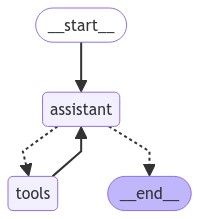

In [7]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
import uuid
from tools.utils import _print_event

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
    "Show me the booking details so far",
]


thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        input={"messages": ("user", question)},
        config=config,
        stream_mode="values",
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_ndf7UQwEIUKGi7UuSl8b9G3Q)
 Call ID: call_ndf7UQwEIUKGi7UuSl8b9G3Q
  Args:
Results: [{'ticket_no': '7240005432906569', 'book_ref': 'C46E9F', 'flight_id': 19250, 'flight_no': 'LX0112', 'departure_airport': 'CDG', 'arrival_airport': 'BSL', 'scheduled_departure': '2024-07-30 14:17:24.166230-04:00', 'scheduled_arrival': '2024-07-30 15:47:24.166230-04:00', 'seat_no': '18E', 'fare_conditions': 'Economy'}]
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2024-07-30 14:17:24.166230-04:00", "scheduled_arrival":